In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astropy.io import ascii
from astropy import constants as const

from tqdm import tqdm

# from scipy.integrate import trapz, simpson
# from scipy.signal import savgol_filter

# from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
from astropy.table import join

In [3]:
file = "C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\table-alma-vla-patrick.txt"
file2 = "C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\HOPS_SED_Fits.tbl.txt"

table = ascii.read(file)
table2 = ascii.read(file2)
# Add 'HOPS-' prefix to each entry in the 'HOPS_ID' column of table2
table2['HOPS_ID'] = ['HOPS-' + str(id_val) for id_val in table2['HOPS_ID']]


# Rename column in `table` to match `table2` if needed
# table.rename_column('source', 'HOPS_ID')

# Now perform the join on the updated columns
matched_table = join(table, table2, keys_left='source', keys_right='HOPS_ID', join_type='inner')

# try to clean up data a bit
mask = (table['lbol'] > 0)

table = table[mask]

In [4]:
names = matched_table['source']
clas = matched_table['class']

# masks for YSO classes
class0 = (clas == "0")
class1 = (clas == "I")
flat = (clas == "Flat")

tbol = matched_table['Tbol']
lbol = matched_table['Lbol']

alma_mass = matched_table['mass_alma_mearth'] * 100 * u.M_earth # disk mass in earth masses
alma_mass_e = matched_table['e_mass_alma_mearth'] * 100 * u.M_earth

vla_mass = matched_table['mass_vla_mearth'] * 100 * u.M_earth # disk mass in earth masses
vla_mass_e = matched_table['e_mass_vla_mearth'] * 100 * u.M_earth

To motivate measuring the fraction of the luminosity from accretion, if you make the assumption that all the luminosity is accretion luminosity, you can calculate from these disk depletion times.

You have to find disk gas masses

$m_{disk}$ (earth masses) * 100 * $M_{earth}$

and then calculate mass accretion rate:

$L = L_{acc} = \eta \frac{GM}{R} \dot{M}$

$ L_{acc}  \frac{R}{\eta GM}  = \dot{M} $

where $\eta$ = 0.8 and M/R is roughly 1/5  solar masses/solar radii

Then take $m_{disk}/\dot{M}$


In [5]:
eta = 0.8  # unitless
G = const.G  # Gravitational constant in m^3 kg^-1 s^-2
m_div_r = ((1/5) * u.solMass / u.solRad)  # solar masses / solar radii

rhs1 = eta * G * m_div_r # combine constants/assumptions into one term (with units)

mdot = (lbol / rhs1).to(u.Msun/u.s) # divide to get accretion rate in solar masses per year

# calculate depletion times
t_dep_alma = (alma_mass/mdot).to(u.year) # depletion time in years
t_dep_vla = (vla_mass/mdot).to(u.year) # depletion time in years

In [6]:
mdot

<Quantity [9.58738115e-15, 2.10039337e-14, 3.15374380e-16, 3.34296843e-15,
           6.93823636e-16, 3.19789621e-14, 2.41702925e-13, 5.67673884e-14,
           3.15374380e-16, 1.95532116e-15, 1.82917140e-15, 6.93823636e-16,
           1.76609653e-15, 6.62286198e-15, 2.01839603e-15, 1.82917140e-15,
           1.26149752e-16, 2.58606992e-15, 3.67663452e-13, 6.04257312e-14,
           2.45992016e-15, 1.05335043e-14, 7.25361074e-15, 9.33508165e-15,
           1.00919802e-15, 1.07227289e-14, 2.08147091e-14, 4.90091787e-14,
           7.19053586e-15, 4.35216644e-15, 9.46123140e-16, 1.81655643e-14,
           9.46123140e-16, 2.52299504e-16, 2.70591218e-14, 1.36241732e-14,
           7.56898512e-16, 2.64914479e-15, 1.07227289e-15, 4.41524132e-15,
           2.79421701e-14, 2.79421701e-14, 6.30748760e-16, 1.70302165e-15,
           2.40946026e-14, 2.83836942e-15, 4.28909157e-15, 8.64125801e-15,
           3.65834281e-15, 2.15085327e-14, 9.75768332e-14, 1.13534777e-15,
           2.46622765e-14

In [7]:
t_dep_alma/t_dep_vla

<Quantity [ 7.32062273e-02,  1.04405372e-01, -5.89697559e-06,
           -1.48084997e-04, -2.51272979e-05, -7.83970481e-05,
            4.35402266e-01,  4.18986765e-01, -3.61636725e-05,
           -2.24182042e-05, -1.15191024e-04, -2.84009375e-04,
           -1.75394115e-05, -8.46667513e-06, -1.65545620e-05,
           -3.23636687e-06, -9.35213056e-05,  3.60626457e-01,
            5.78956204e-01,  3.87264618e-02, -4.00485249e-05,
           -1.57451673e-04, -1.23212244e-05, -5.07873235e-04,
            6.06771674e-01,  5.98543486e-02,  6.99605162e-02,
           -6.94273422e-05, -1.57866825e-04, -2.73615425e-04,
           -3.73939768e-06, -4.95758072e-05, -3.70303401e-06,
           -6.11515763e-06, -3.36697306e-05, -4.87606548e-05,
           -3.78788258e-06, -7.04849190e-06, -2.64818447e-05,
            1.01638862e-01,  1.68864332e-01,  1.68864332e-01,
           -1.95636559e-05, -5.66727839e-05, -1.29815281e-04,
           -8.66364503e-06, -8.00667467e-05,  1.80248049e-01,
        

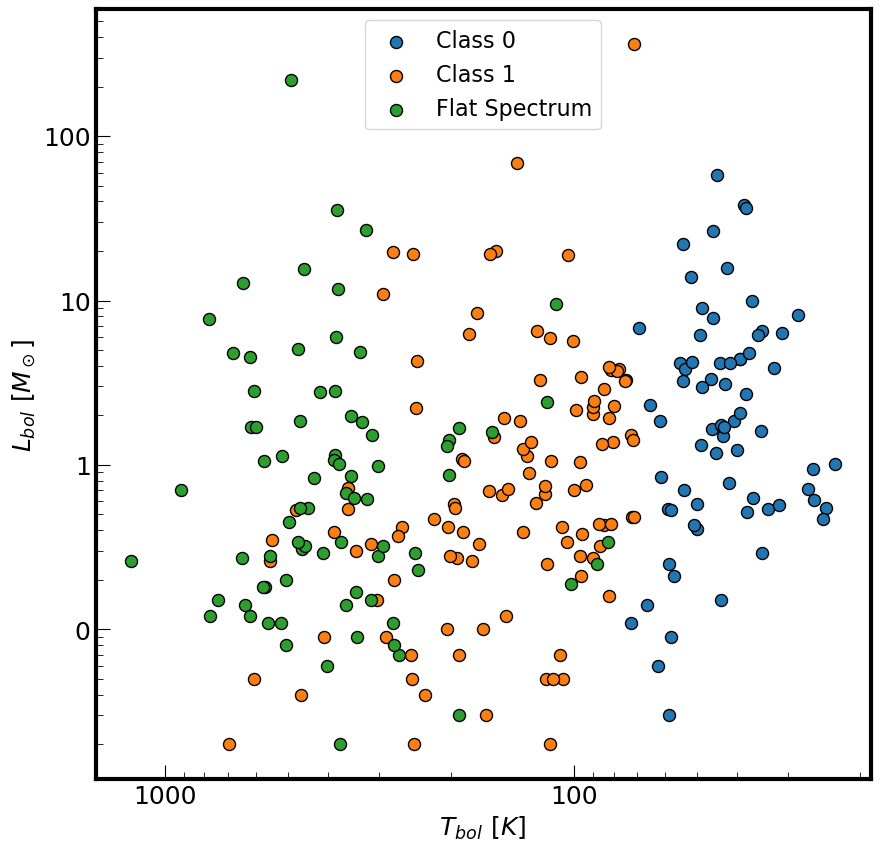

In [33]:
from matplotlib.ticker import ScalarFormatter
fig = plt.figure(figsize=(10,10))

plt.scatter(tbol[class0], lbol[class0], s=75, edgecolor='k', label='Class 0')

plt.scatter(tbol[class1], lbol[class1], s=75, edgecolor='k', label='Class 1')

plt.scatter(tbol[flat], lbol[flat], s=75, edgecolor='k', label='Flat Spectrum')

plt.xscale('log')
plt.gca().invert_xaxis()
# Set x-axis to plain formatting
plt.gca().xaxis.set_major_formatter(ScalarFormatter())

plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

plt.ticklabel_format(axis='both', style='plain')

plt.xlabel(r'$T_{bol}$ $[K]$')
plt.ylabel(r'$L_{bol}$ $[M_\odot]$')

plt.legend(loc='best',frameon=True)
plt.show()

figure above, evolution?

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

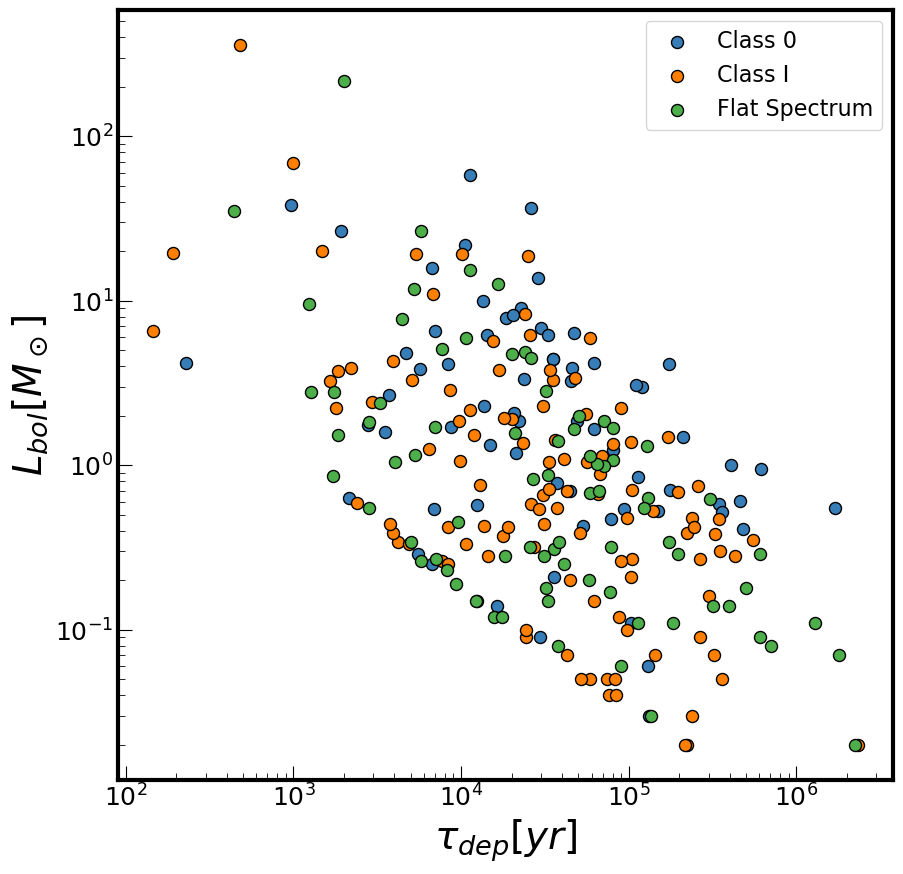

In [40]:
fig = plt.figure(figsize=(10,10))

# '#377eb8', '#ff7f00', '#4daf4a'
plt.scatter(t_dep_alma[class0], lbol[class0],
    edgecolor='k', facecolor='#377eb8',
    s=75, marker='o', label='Class 0')
plt.scatter(t_dep_alma[class1], lbol[class1],
    edgecolor='k', facecolor='#ff7f00',
    s=75, marker='o', label='Class I')
plt.scatter(t_dep_alma[flat], lbol[flat],
    edgecolor='k', facecolor='#4daf4a',
    s=75, marker='o', label='Flat Spectrum')
# plt.scatter(t_dep_vla, lbol, edgecolor='k', label='VLA')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\tau_{dep} [yr]$', fontsize=28)
plt.ylabel(r'$L_{bol} [M_\odot]$', fontsize=28)

plt.legend(bbox_to_anchor=(1,1))
plt.show()

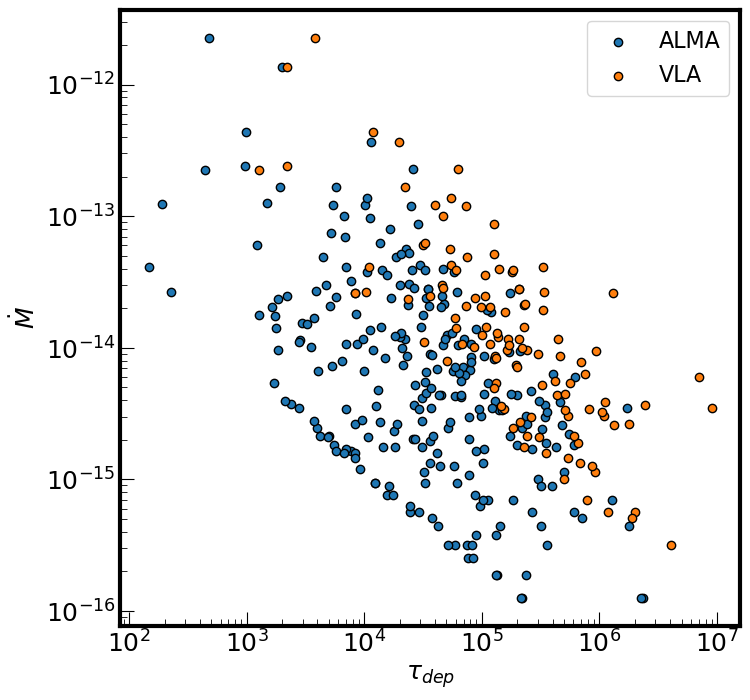

In [10]:
fig = plt.figure(figsize=(8,8))

plt.scatter(t_dep_alma, mdot, edgecolor='k', label='ALMA')
plt.scatter(t_dep_vla, mdot, edgecolor='k', label='VLA')

plt.xscale('log')
# Set x-axis to plain formatting
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())

plt.yscale('log')
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.ticklabel_format(axis='x', style='scientific')

plt.xlabel(r'$\tau_{dep}$')
plt.ylabel(r'$\dot{M}$')

plt.legend()
plt.show()